<a href="https://colab.research.google.com/github/SoniaPMi/AI-3-PyTorch/blob/main/Time_series_prediction_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline passenger prediction using LSTM in PyTorch

## Setup

In [1]:
import torch
import torch.nn as nn
import numpy
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
flight_data.shape

(144, 3)

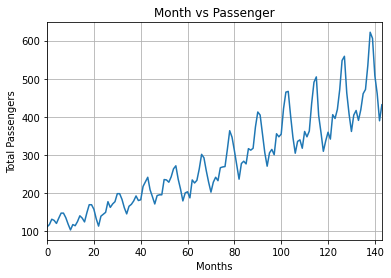

In [4]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.show()

# Preprocessing

In [5]:
dataset = np.array(flight_data['passengers'], dtype='float32')

# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1)) # reshape as data has a single feature
dataset = torch.FloatTensor(dataset).view(-1) # convert to torch tensor

In [6]:
# Function to create dataset matrix using a time window of size "lag"
lag = 3

def create_dataset(input_data, lag):
    dataX, dataY = [], []
    L = len(input_data)
    for i in range(L-lag):
        train_seq = input_data[i:i+lag]
        train_label = input_data[i+lag:i+lag+1]
        dataX.append(train_seq)
        dataY.append(train_label)
    return dataX,dataY

In [15]:
# Create dataset matrix and split into train/test

dataX, dataY = create_dataset(dataset, lag) # completar
print(dataX[0:5])
print(dataY[0:5])

train_size = int(len(dataset)*0.67) # completar
#test_size = int(len(dataset) - train size)
trainX, trainY = dataX[0:train_size], dataY[0:train_size]
testX, testY = dataX[train_size:len(dataset)], dataY[train_size:len(dataset)]
print(len(trainX))
print(len(testX))

[tensor([0.0154, 0.0270, 0.0541]), tensor([0.0270, 0.0541, 0.0483]), tensor([0.0541, 0.0483, 0.0328]), tensor([0.0483, 0.0328, 0.0598]), tensor([0.0328, 0.0598, 0.0849])]
[tensor([0.0483]), tensor([0.0328]), tensor([0.0598]), tensor([0.0849]), tensor([0.0849])]
96
45


## Create LSTM model

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1):
        super(LSTM,self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1] # output for last timestep

In [31]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
print(model)

LSTM(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


## Train model

In [33]:
epochs = 150

for i in range(epochs):
    for seq, label in zip(trainX, trainY):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

    if i%25 == 1: # print loss every 25 epochs
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')

print(f'epoch: {i:3} loss: {loss.item():10.10f}')

epoch:   1 loss: 0.00122247
epoch:  26 loss: 0.00765988
epoch:  51 loss: 0.00878246
epoch:  76 loss: 0.00913895
epoch: 101 loss: 0.00908925
epoch: 126 loss: 0.01011446
epoch: 149 loss: 0.0093297688


## Predict

In [35]:
model.eval()

testPredict=[]
for i in range(len(testX)):
    seq = testX[i]
    with torch.no_grad():
      testPredict.append(model(seq).item())

In [36]:
# invert scaling
testPredict2 = scaler.inverse_transform(np.array(testPredict).reshape(-1,1))
testY2 = scaler.inverse_transform(np.array(testY).reshape(-1,1))

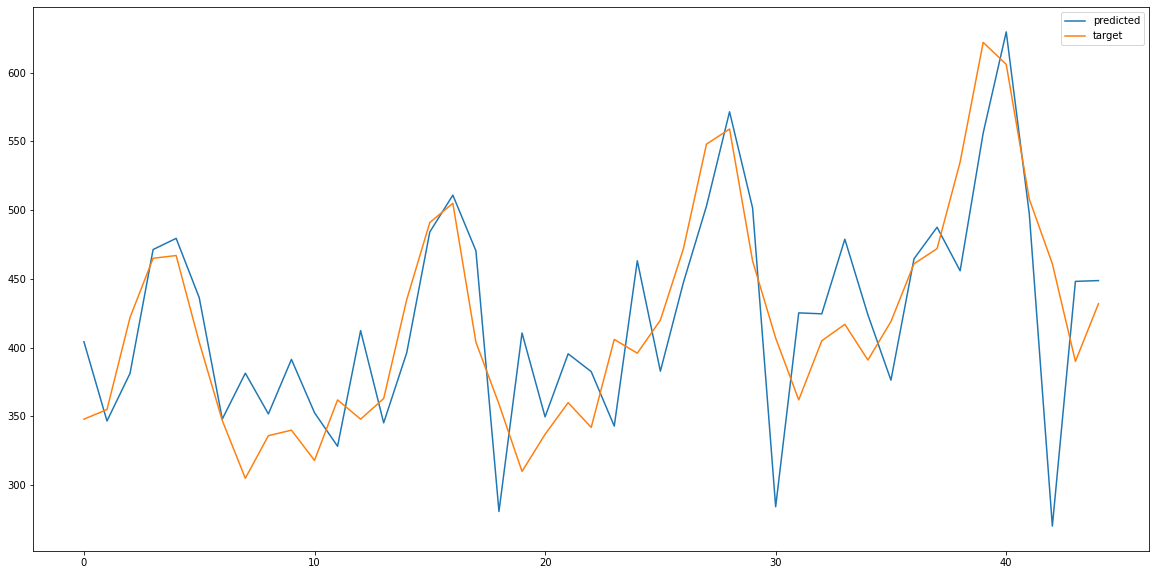

In [37]:
plt.figure(figsize=(20,10))
plt.plot(testPredict2, label='predicted')
plt.plot(testY2, label='target')
plt.legend()
plt.show()

In [38]:
# plot baseline and predictions
testPredictPlot = np.empty_like(dataset).reshape(-1,1)
testPredictPlot[:,:] = np.nan
testPredictPlot[# completar] = testPredict2

plt.figure(figsize=(20,10))
dataset2 = scaler.inverse_transform(np.array(dataset).reshape(-1,1))
plt.plot(dataset2)
plt.plot(testPredictPlot)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.show()

SyntaxError: ignored